<a href="https://colab.research.google.com/github/mohamedelziat50/Fruit-Recognition-MIU/blob/main/Fruit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Processing project for fruit recognition using the Fruits-360 dataset.

### Import The Necessary Libraries

In [82]:
import kagglehub
import os, sys
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Import The [Fruits-360 Dataset](https://www.kaggle.com/datasets/moltean/fruits) From Kaggle

In [83]:
# Load the dataset directly from kaggle (gives us the root path)
kaggle_dataset_path = kagglehub.dataset_download("moltean/fruits")

# Get the correct dataset path, by going inside the folders
dataset_path = os.path.join(kaggle_dataset_path, "fruits-360_100x100", "fruits-360")
print(f"Updated dataset path: {dataset_path}")

# Preview the contents of the path to double-check
print("\nFiles in the Dataset directory:", os.listdir(dataset_path))

Using Colab cache for faster access to the 'fruits' dataset.
Updated dataset path: /kaggle/input/fruits/fruits-360_100x100/fruits-360

Files in the Dataset directory: ['LICENSE', 'Training', 'README.md', 'Test']


### Store the Training & Testing paths independently

In [84]:
# Join the correct paths (checkout out the dataset's folder names on kaggle)
training_path = os.path.join(dataset_path, "Training")
testing_path = os.path.join(dataset_path, "Test")

# Display the Paths
print(f"Training Path: {training_path}")
print(f"Testing Path: {testing_path}\n")

# Check if directories exist
print("Training directory exists:", os.path.exists(training_path))
print("Testing directory exists:", os.path.exists(testing_path))

Training Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Testing Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test

Training directory exists: True
Testing directory exists: True


### Load the training dataset
#### Create a `Fruit` class that will store the fruit's image & label (Training Data)

In [85]:
class Fruit:
  # Constructor With a 2 properties: image & label
  def __init__(self, image, label):
      self.image = image
      self.label = label

  # Getter for image
  @property
  def image(self):
      return self._image

  # Setter for image
  @image.setter
  def image(self, image):
      self._image = image

  # Getter for label
  @property
  def label(self):
      return self._label

  # Setter for label
  @label.setter
  def label(self, label):
      self._label = label

#### Main function that properly fetches the training data & returns a fruits list

In [86]:
def get_categories(fruit_categories):
    # Store in a list of Fruit Objects that have image & label
    fruits = []

    # Loop over each category
    for category in fruit_categories:
        category_path = os.path.join(training_path, category)

        # Get a list of images in that category
        category_images = os.listdir(category_path)

        # Loop over the images (ONE Image per category for now)
        for image in category_images[:1]:
            image_path = os.path.join(category_path, image)

            # Read the image using OpenCV & store inside the Fruit class
            fruit = Fruit(cv.imread(image_path), category)
            fruits.append(fruit)

    return sorted(fruits, key=lambda fruit: fruit.label)


#### Get the fruit categories & fruit list objects

In [87]:
# Get a list of all fruit categories (subdirectories) in the training path
fruit_categories = os.listdir(training_path)

# Display how many labels/categories we have
print("Number of Fruit Categories (Labels):", len(fruit_categories), end="\n\n")

# Get a list of all fruits as `Fruit` objects with image & label
fruits = get_categories(fruit_categories)

# Display how many fruit images we have
print("Number of Fruit Images (Training Data):", len(fruits))

Number of Fruit Categories (Labels): 227

Number of Fruit Images (Training Data): 227


#### Display a random portion of the fruits using Matplotlib

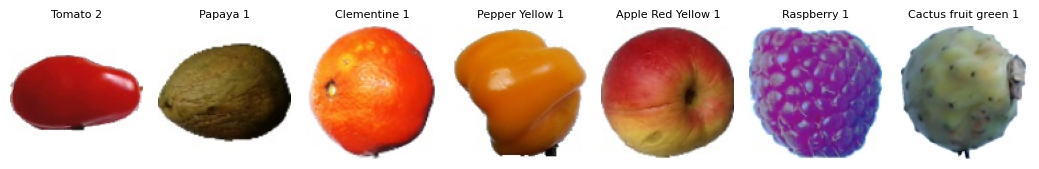

In [91]:
fruits_to_show = random.sample(fruits, 7)
rows, cols = 1, len(fruits_to_show)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, 2))

for ax, fruit in zip(axes, fruits_to_show):
    # Convert to RGB (Matplotlib) from BGR (OpenCV)
    rgb_image = cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB)

    # Show image
    ax.imshow(rgb_image)

    # Label on top
    ax.set_title(fruit.label, fontsize=8)

    # Remove ticks
    ax.axis('off')

plt.tight_layout()
plt.show()